In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=100, replications=20, n=500,
    # allowed_functions=['identity']
)
data['ATE_true'].describe()

count    2000.000000
mean        0.034257
std         6.607735
min       -89.656475
25%        -0.888130
50%        -0.000102
75%         0.894992
max        99.562500
Name: ATE_true, dtype: float64

In [120]:
pd.DataFrame(data.iloc[100].Y).describe()

,0
count,500.000000
mean,-0.167204
std,7.484860
min,-21.455707
25%,-5.669664
50%,0.411278
75%,5.270405
max,20.141363


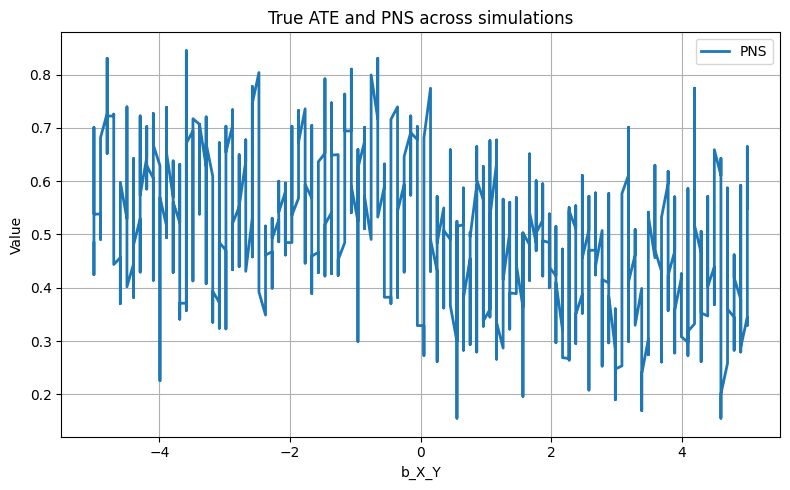

In [ ]:
PlottingUtil.plot_ate_pns(data, window=10)

In [4]:
binaryIV = BinaryIV('IV Dag', data)

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run_all_bounding_algorithms(algorithms)

Running ATE_2SLS-0.99...
ATE_2SLS-0.99 completed in 0.19 seconds.
Running ATE_2SLS-0.98...
ATE_2SLS-0.98 completed in 0.25 seconds.
Running ATE_causaloptim...
ATE_causaloptim completed in 6.28 seconds.
Running ATE_autobound...
ATE_autobound completed in 4.71 seconds.
Running ATE_entropybounds-0.80...
ATE_entropybounds-0.80 completed in 0.59 seconds.
Running ATE_entropybounds-0.20...
ATE_entropybounds-0.20 completed in 0.59 seconds.
Running ATE_entropybounds-0.10...
ATE_entropybounds-0.10 completed in 0.63 seconds.
Running ATE_nonpara...
ATE_nonpara completed in 0.01 seconds.
Total runtime: 13.26 seconds.


             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width
           PNS_nonpara          0.00            16.00          0.1784
       PNS_causaloptim          4.00             9.38          0.4198
         PNS_autobound          1.00             0.00          0.4283
PNS_entropybounds-0.10          0.00             0.00          0.5021
PNS_entropybounds-0.20          0.00             0.00          0.5752
PNS_entropybounds-0.80          0.00             0.00          0.7197
    PNS_zaffalonbounds           N/A              N/A             N/A


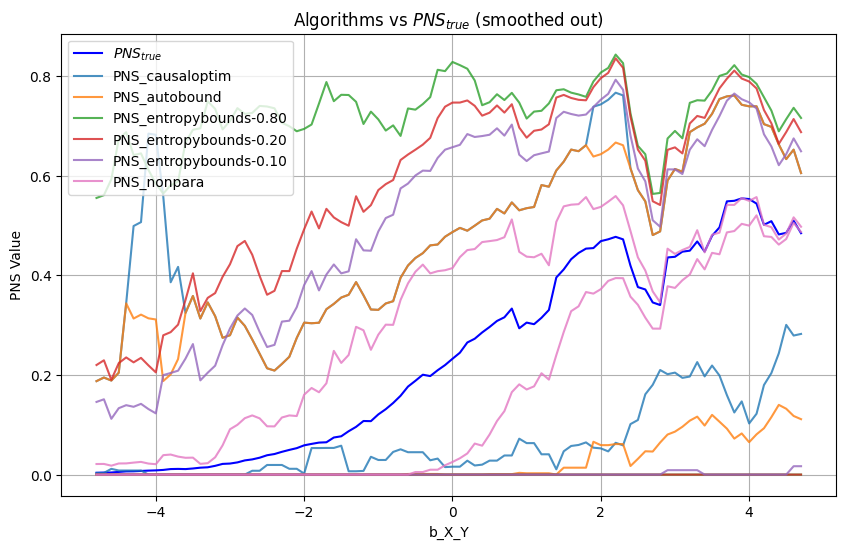

In [28]:
algorithms = list(runtimes['runtimes'].keys())
ate_algs = binaryIV.get_algorithms('PNS')
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, ate_algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'PNS', ate_algs, 5, False)